# Data on breakdown

Overview
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.



# Import dependables

In [1]:
import pandas as pd
import math
import statistics
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics

# Save required CSVs

In [2]:
train_df = pd.read_csv("train.csv") # Information about what we know
test_df = pd.read_csv("test.csv") # test that train when algo is made
gender_df = pd.read_csv("gender_submission.csv") # results

# Centralize all data

In [3]:
main_df = test_df.join(gender_df.set_index('PassengerId'), on='PassengerId')

In [4]:
df = pd.concat([train_df, main_df],ignore_index=True)

C:\Users\dhlec\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


# Remove NAs

In [5]:
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64

In [6]:
# Impute na in age
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [7]:
# Drop cabin, too many NAs
df.drop(['Cabin'], axis=1, inplace = True)

In [8]:
# Drop 2 missing embarks, remove
df = df.dropna()

# Pre-preprocessing questions and answers

Is there a visuale correlation between surviving the titanic and the passenger's sex?

In [9]:
survived_df = df[df['Survived'] == 1]

In [10]:
data = survived_df[['Sex','Survived']].groupby('Sex').count()

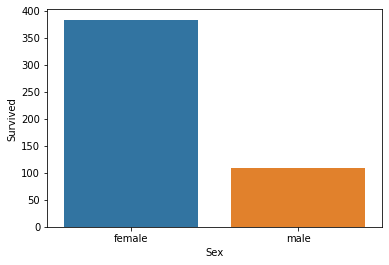

In [11]:
ax =sns.barplot(y="Survived",x=data.index, data=data)

Between age and survival?

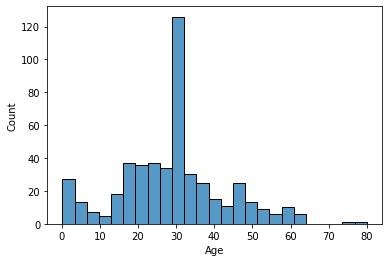

In [12]:
ax = sns.histplot(data=survived_df[['Age','Survived']], x="Age")

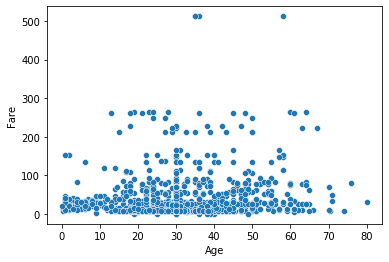

In [13]:
ax = sns.scatterplot(data=df, x='Age', y="Fare")

# Pre-process

In [14]:
df.drop(columns = ['Name','Ticket'], inplace = True) #Name we cannot measure for relvantcy, tickets will require formatting.

In [15]:
df.head(5) # Looks good

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,0,1,3,male,1,0
1,38.0,C,71.2833,0,2,1,female,1,1
2,26.0,S,7.9250,0,3,3,female,0,1
3,35.0,S,53.1000,0,4,1,female,1,1
4,35.0,S,8.0500,0,5,3,male,0,0


In [16]:
# Preprocess Embarked
df.Embarked = pd.Categorical(df.Embarked)
df['embarkedEncoded'] = df.Embarked.cat.codes

In [17]:
df.drop(columns = ['Embarked'], inplace = True)

In [18]:
# Make sex into dummies
df['Sex'] = pd.get_dummies(df['Sex'])['male']

In [19]:
# Normalize distributed intengers
age_normalized = sklearn.preprocessing.normalize([df['Age']], norm = 'l2')
fare_normalized = sklearn.preprocessing.normalize([df['Fare']],  norm = 'l2')

In [20]:
df['Age'] = age_normalized[0]
df['Fare'] = fare_normalized[0]

In [21]:
# We are ready!
df.set_index("PassengerId", inplace = True)

In [22]:
df.describe()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,embarkedEncoded
count,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.00000,1306.000000,1306.000000
mean,0.025419,0.014950,0.385911,2.296325,0.644717,0.50000,0.376723,1.492343
std,0.010940,0.023294,0.866357,0.837037,0.478782,1.04258,0.484750,0.814817
min,0.000145,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
25%,0.018748,0.003553,0.000000,2.000000,0.000000,0.00000,0.000000,1.000000
50%,0.025465,0.006504,0.000000,3.000000,1.000000,0.00000,0.000000,2.000000
75%,0.029827,0.014073,0.000000,3.000000,1.000000,1.00000,1.000000,2.000000
max,0.068176,0.230540,9.000000,3.000000,1.000000,8.00000,1.000000,2.000000


In [23]:
y = df['Survived']

In [24]:
X = df.drop(columns = ['Survived'])

# Let's train the algos!

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
logreg = LogisticRegression()

# fit the model with data
logFormula = logreg.fit(X_train,y_train)

#
# y_pred=logreg.predict(X_test)

In [27]:
log_y_pred=logreg.predict(X_test)

In [28]:
log_y_pred = list(log_y_pred)

In [29]:
accuracy_score(y_test, log_y_pred)

0.8677494199535963

# Let's use SVM now!

In [30]:
algo = svm.SVC()
algo.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
svm_y_predict = algo.predict(X_test)

In [32]:
accuracy_score(y_test,svm_y_predict)

0.8700696055684455

# Decision tree

In [33]:
from sklearn import tree
from sklearn.datasets import load_iris

In [34]:
# Create and score a decision tree classifier
clf = tree.DecisionTreeClassifier()

In [35]:
clf = clf.fit(X_train,y_train)
dt_y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, dt_y_pred))

Accuracy: 0.8097447795823666


# Put them all together

In [36]:
df = pd.DataFrame(data = {'Test Group': y_test, "logred pred":log_y_pred, "SVM Prediction": svm_y_predict, "Decision Tree Prediction": dt_y_pred})

In [47]:
X = df.drop(columns='Test Group')
y = df['Test Group']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
logreg = LogisticRegression()

# fit the model with data
logFormula = logreg.fit(X_train,y_train)

#
# y_pred=logreg.predict(X_test)

In [27]:
log_y_pred=logreg.predict(X_test)

In [28]:
log_y_pred = list(log_y_pred)

In [29]:
accuracy_score(y_test, log_y_pred)

0.8677494199535963

In [46]:
for i in range(len(df['Test Group'])):
    print(df['Test Group'].iloc[i])

0
0
0
1
0
1
1
0
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
1
1
1
1
1
0
1
1
1
1
0
0
1
0
1
1
1
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
1
1
0
1
0
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
1
1
0
0
0
1
1
0
1
1
1
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
1
0
0
0
1
0
0
0
1
0
0
1
1
1
1
1
0
1
0
0
0
0
0
0
0
1
0
0
1
1
0
0
1
0
0
1
0
0
1
1
1
0
0
1
1
1
0
1
0
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
1
0
1
1
0
0
0
1
0
1
0
1
0
0
1
0
0
1
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
1
1
1
0
1
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
0
0
0
1
0
1
0
0
0
0
1
0
0
1
0
0
0
1
0
1
0
0
0
0
1
1
1
0
0
0
1
1
0
1
1
1
0
1
0
0
0
0
1
1
0
1
0
1
0
1
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
1
0
0
0
1
1
0
1
0
0
1
1
1
0
0
1
1
0
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
1
1
0
1
1
1
0
1
0
1
0
0
0
0
1
0
0
0
0
1
1
0
0
1
0
1
0
0
0
1
0
0
1
0
0
0
0
0
1
1
0
0
0
1
1
0
1
0
1
1
0
0
0
0
0
1
0
1
0
0
1
1
1
0
0
0
0
1
0
0
1
